## Homework 3

In [289]:
import pandas as pd
import numpy as np

df = pd.read_csv('bank-full.csv', sep=';')
df = df.drop(columns=['default', 'loan'])
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Question 1

What is the most frequent observation (mode) for the column education?

In [290]:
print(f'{df.education.value_counts().idxmax()} is the mode for education')

secondary is the mode for education


### Question 2
What are the two features that have the biggest correlation in this dataset?

<Axes: >

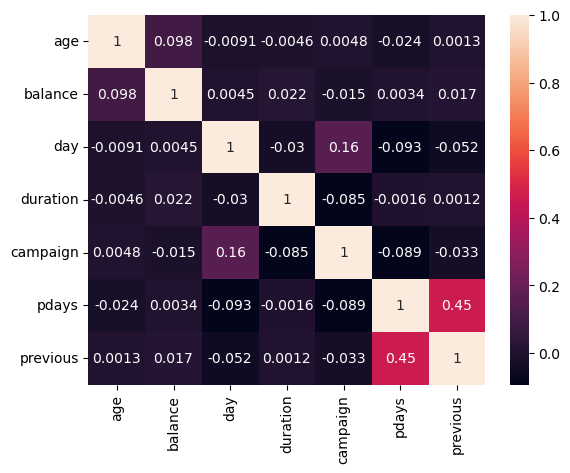

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical = list(df.dtypes[df.dtypes == 'int'].index)
sns.heatmap(df[numerical].corr(), annot=True)

`pdays` and `previous` have the biggest correlation (0.45)

#### Encoding
Convert y to a binary series, where yes/no becomes 1/0

In [292]:
df.y = (df.y == 'yes').astype('int')
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

#### Split the Data

In [293]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

### Question 3

In [294]:
from sklearn.metrics import mutual_info_score

categorical = list(df_train.dtypes[df_train.dtypes == object].index)

def mutual_info_churn(series):
    return mutual_info_score(df_full_train.y, series)

mutual_info = df_full_train[categorical].apply(mutual_info_churn)
print(f'{mutual_info.idxmax()} has the highest mutual information score of {round(mutual_info.max(), 2)}')

poutcome has the highest mutual information score of 0.03


### Question 4

In [295]:
from sklearn.linear_model import LogisticRegression

df_train_encoded = pd.get_dummies(df_train[categorical], drop_first=True, dtype='int')
df_val_encoded = pd.get_dummies(df_val[categorical], drop_first=True, dtype='int')
df_test_encoded = pd.get_dummies(df_test[categorical], drop_first=True, dtype='int')

df_train_rest = df_train.drop(columns=categorical)
df_val_rest = df_val.drop(columns=categorical)
df_test_rest = df_test.drop(columns=categorical)

X_train = pd.concat([df_train_rest, df_train_encoded], axis=1)
X_val = pd.concat([df_val_rest, df_val_encoded], axis=1)
X_test = pd.concat([df_test_rest, df_test_encoded], axis=1)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]

deposit_decision = y_pred >= 0.5
baseline_accuracy = (y_val == deposit_decision.astype('int')).mean()

print(f'The model has an accuracy score of: {round((baseline_accuracy), 2)}')

The model has an accuracy score of: 0.9


In [296]:
list(X_train.columns[X_train.columns.str.contains('marital')])[0]

'marital_married'

### Question 5

In [297]:
target_f = ['age', 'balance', 'marital_married', 'marital_single', 'previous']
accuracies = {}

for feature in target_f:

    X_train_new = X_train.copy()
    X_val_new = X_val.copy()
    
    X_train_new = X_train.drop(columns=[feature])
    X_val_new = X_val.drop(columns=[feature])
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_new, y_train)
    y_pred = model.predict_proba(X_val_new)[:,1]
    deposit_decision = y_pred >= 0.5
    new_accuracy = (y_val == deposit_decision.astype('int')).mean()
    diff = abs(baseline_accuracy - new_accuracy)
    
    accuracies[feature] = diff

print(f'Removing the {min(accuracies, key=accuracies.get)} column makes the smallest difference to accuracy, with a difference of {accuracies[min(accuracies, key=accuracies.get)]}')

Removing the balance column makes the smallest difference to accuracy, with a difference of 0.00011059500110588427


In [305]:
C_vals = [0.01, 0.1, 1,  10,  100]
C_accuracies = {}

for C in C_vals:
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]

    deposit_decision = y_pred >= 0.5
    accuracy = (y_val == deposit_decision.astype('int')).mean()
    
    C_accuracies[C] = round(accuracy, 4)
    
max(C_accuracies, key=C_accuracies.get)

0.1